## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [102]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from utils import plot_images
%matplotlib inline

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


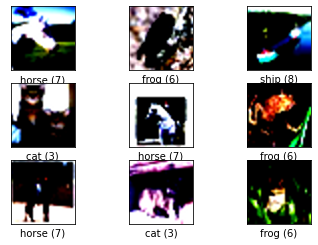

In [103]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

In [107]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.maxPool1 = nn.MaxPool2d(2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(64)
        self.maxPool2 = nn.MaxPool2d(2, stride=2)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchNorm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.batchNorm6 = nn.BatchNorm2d(128)
        self.maxPool3 = nn.MaxPool2d(2, stride=2)
        
        self.fc1 = nn.Linear(2048, 10)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################

        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = F.relu(x)
        x = self.maxPool1(x)
        
        x = self.conv3(x)
        x = self.batchNorm3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.batchNorm4(x)
        x = F.relu(x)
        x = self.maxPool2(x)
        
        x = self.conv5(x)
        x = self.batchNorm5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.batchNorm6(x)
        x = F.relu(x)
        x = self.maxPool3(x)
        
        x = self.fc1(x.view(x.size()[0], 2048))
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        outputs = self.forward(x)
        return torch.argmax(F.softmax(outputs).data, 1)

In [113]:
net = ConvNet()
print(net)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm5): BatchNorm2d(128, eps=1e-05, 

In [111]:
#Overfit a small batch

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
epochs = 500

for e in range(epochs):

    #Reset the gradient
    optimizer.zero_grad()

    # Feedforward pass
    output = net.forward(images)

    # Compute the loss
    loss = criterion(output, labels)

     # Compute the gradient
    loss.backward()

    # Update the weights
    optimizer.step()

    accuracy = torch.mean((net.predict(images) == labels).to(torch.float32))
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Test accuracy: {:.4f}..".format(accuracy)
         )


C:\Users\martin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/500.. Test accuracy: 0.2031..
Epoch: 2/500.. Test accuracy: 0.1250..
Epoch: 3/500.. Test accuracy: 0.1562..
Epoch: 4/500.. Test accuracy: 0.1875..
Epoch: 5/500.. Test accuracy: 0.1875..
Epoch: 6/500.. Test accuracy: 0.2188..
Epoch: 7/500.. Test accuracy: 0.2500..
Epoch: 8/500.. Test accuracy: 0.2500..
Epoch: 9/500.. Test accuracy: 0.3125..
Epoch: 10/500.. Test accuracy: 0.2969..
Epoch: 11/500.. Test accuracy: 0.2656..
Epoch: 12/500.. Test accuracy: 0.3125..
Epoch: 13/500.. Test accuracy: 0.3125..
Epoch: 14/500.. Test accuracy: 0.2969..
Epoch: 15/500.. Test accuracy: 0.3438..
Epoch: 16/500.. Test accuracy: 0.3438..
Epoch: 17/500.. Test accuracy: 0.3438..
Epoch: 18/500.. Test accuracy: 0.3906..
Epoch: 19/500.. Test accuracy: 0.4375..
Epoch: 20/500.. Test accuracy: 0.5156..
Epoch: 21/500.. Test accuracy: 0.4688..
Epoch: 22/500.. Test accuracy: 0.5000..
Epoch: 23/500.. Test accuracy: 0.4219..
Epoch: 24/500.. Test accuracy: 0.4844..
Epoch: 25/500.. Test accuracy: 0.5000..
Epoch: 26

KeyboardInterrupt: 

In [120]:
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-5, weight_decay = 1e-4)

epochs = 10
steps = 0
running_loss = 0
print_every = 20
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #                                                                            #
        ################################################################################
        #Reset the gradient
        optimizer.zero_grad()
        
        # Feedforward pass
        output = net.forward(images)
        
        # Compute the loss
        loss = criterion(output, labels)
        
         # Compute the gradient
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            with torch.no_grad():
                for ii, (images, labels) in enumerate(valloader):

                    ################################################################################
                    # TODO:                                                                        #
                    # Calculate the accuracy                                                       #
                    ################################################################################
                    accuracy += torch.mean((net.predict(images) == labels).to(torch.float32)) 
                    ################################################################################
                    #                              END OF YOUR CODE                                #
                    ################################################################################
                acc_epoch.append(accuracy/(ii+1))
                print("Epoch: {}/{}..".format(e+1, epochs),
                      "Loss: {:.4f}..".format(running_loss/print_every),
                      "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                      "{:.4f} s/batch".format((stop - start)/print_every)
                     )
                running_loss = 0
                start = time.time()    

C:\Users\martin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/10.. Loss: 0.0171.. Test accuracy: 0.8658.. 1.4675 s/batch
Epoch: 1/10.. Loss: 0.0176.. Test accuracy: 0.8641.. 1.0716 s/batch
Epoch: 1/10.. Loss: 0.0167.. Test accuracy: 0.8619.. 1.2322 s/batch
Epoch: 1/10.. Loss: 0.0192.. Test accuracy: 0.8555.. 0.7863 s/batch
Epoch: 1/10.. Loss: 0.0197.. Test accuracy: 0.8646.. 1.1814 s/batch
Epoch: 1/10.. Loss: 0.0194.. Test accuracy: 0.8555.. 1.0771 s/batch
Epoch: 1/10.. Loss: 0.0153.. Test accuracy: 0.8701.. 0.5146 s/batch
Epoch: 1/10.. Loss: 0.0168.. Test accuracy: 0.8617.. 0.5701 s/batch
Epoch: 1/10.. Loss: 0.0157.. Test accuracy: 0.8582.. 0.6064 s/batch
Epoch: 1/10.. Loss: 0.0196.. Test accuracy: 0.8602.. 0.5749 s/batch
Epoch: 1/10.. Loss: 0.0212.. Test accuracy: 0.8600.. 0.5690 s/batch
Epoch: 1/10.. Loss: 0.0155.. Test accuracy: 0.8600.. 0.5857 s/batch
Epoch: 1/10.. Loss: 0.0154.. Test accuracy: 0.8592.. 0.6275 s/batch
Epoch: 1/10.. Loss: 0.0200.. Test accuracy: 0.8613.. 0.5794 s/batch
Epoch: 1/10.. Loss: 0.0191.. Test accuracy: 0.85

KeyboardInterrupt: 

Save best trained model.

In [118]:
torch.save(net.state_dict(), 'model86.ckpt')

In [92]:
lr = 0.05

In [99]:
lr /= 2
print(5*lr)

0.001953125
